### Email classification and masking

#### Importing necessary library

In [1]:
#Importing necessary library

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns


### Load data set¶

In [2]:
## Load data set
df=pd.read_csv("/Users/amalthomas/Desktop/combined_emails_with_natural_pii.csv")
df.head()

,email,type
0,Subject: Unvorhergesehener Absturz der Datenan...,Incident
1,Subject: Customer Support Inquiry\n\nSeeking i...,Request
2,Subject: Data Analytics for Investment\n\nI am...,Request
3,Subject: Krankenhaus-Dienstleistung-Problem\n\...,Incident
4,"Subject: Security\n\nDear Customer Support, I ...",Request


In [3]:
#Number of rows and columns
df.shape

(24000, 2)

In [4]:
df['type'].value_counts()

type
Incident    9586
Request     6860
Problem     5037
Change      2517
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='type'>

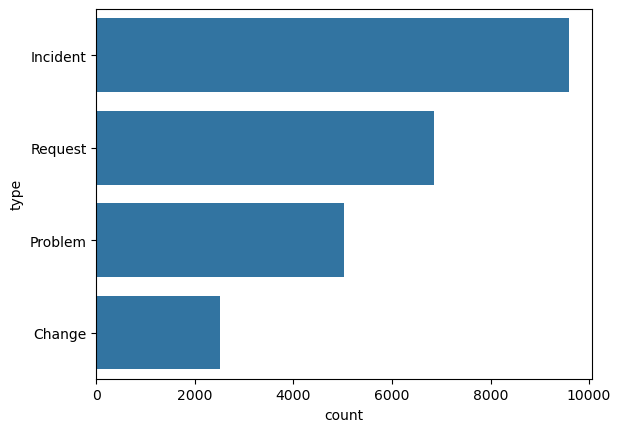

In [5]:
sns.countplot(df['type'])

In [6]:
## duplicated data
df.duplicated().sum()

0

In [7]:
## null values
df.isnull().sum()

email    0
type     0
dtype: int64

In [8]:
# Split into subject and body using newline
def split_subject_and_body(text):
    lines = str(text).split('\n', 1)
    subject = lines[0].strip()
    body = lines[1].strip() if len(lines) > 1 else ''
    return pd.Series([subject, body])

# Apply to your column (replace 'subject_body' with the actual column name)
df[['subject', 'body']] = df['email'].apply(split_subject_and_body)
df.head()

,email,type,subject,body
0,Subject: Unvorhergesehener Absturz der Datenan...,Incident,Subject: Unvorhergesehener Absturz der Datenan...,Die Datenanalyse-Plattform brach unerwartet ab...
1,Subject: Customer Support Inquiry\n\nSeeking i...,Request,Subject: Customer Support Inquiry,Seeking information on digital strategies that...
2,Subject: Data Analytics for Investment\n\nI am...,Request,Subject: Data Analytics for Investment,I am contacting you to request information on ...
3,Subject: Krankenhaus-Dienstleistung-Problem\n\...,Incident,Subject: Krankenhaus-Dienstleistung-Problem,Ein Medien-Daten-Sperrverhalten trat aufgrund ...
4,"Subject: Security\n\nDear Customer Support, I ...",Request,Subject: Security,"Dear Customer Support, I am reaching out to in..."


### Masking sensitive data

In [9]:
import re

def mask_pii_pci(text: str):
    patterns = {
        "full_name": r"\b([A-Z][a-z]+(?:\s[A-Z][a-z]+)+)\b",
        "email": r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b",
        "phone_number": r"\b(?:\+91[\-\s]?)?[6-9]\d{9}\b",
        "dob": r"\b(?:\d{1,2}[\/\-]){2}\d{2,4}\b",
        "aadhar_num": r"\b\d{4}[\s-]?\d{4}[\s-]?\d{4}\b",
        "credit_debit_no": r"\b(?:\d[ -]*?){13,16}\b",
        "cvv_no": r"\b\d{3}\b",
        "expiry_no": r"\b(0[1-9]|1[0-2])[\/\-]?\d{2,4}\b",
    }

    entities = []
    masked_text = text
    offset = 0  # To keep track of character shifts due to masking

    for entity_name, pattern in patterns.items():
        for match in re.finditer(pattern, masked_text):
            start = match.start()
            end = match.end()
            entity_text = match.group(0)

            # Adjust start and end with current offset
            adjusted_start = start + offset
            adjusted_end = end + offset

            # Create masked version
            replacement = f"[{entity_name}]"
            shift = len(replacement) - len(entity_text)
            offset += shift

            # Replace entity in masked text (once, at the current match only)
            masked_text = masked_text[:start] + replacement + masked_text[end:]

            entities.append({
                "position": [start, start + len(replacement)],
                "classification": entity_name,
                "entity": entity_text
            })

    return masked_text, entities
df['masked_email_text'] = df['body'].apply(lambda x: mask_pii_pci(x)[0])

In [10]:
##1. Refactor Your Function for Pipeline Use
##Currently, your function works on a single string. Let's wrap it so it works on a whole pandas column (like .apply()):

def mask_pii_column(series):
    return series.apply(mask_pii_pci)

from sklearn.preprocessing import FunctionTransformer
masking_transformer = FunctionTransformer(mask_pii_column)



### Categorizing the emails¶

In [11]:
# Define rule-based labeling function
def categorize_email(text):
    #text = text.lower()
    if any(word in text for word in ['billing', 'invoice', 'charge', 'refund', 'payment','overcharged','transaction']):
        return 'Billing Issues'
    elif any(word in text for word in ['account', 'login', 'reset', 'password', 'username','change email','profile','personal info']):
        return 'Account Management'
    elif any(word in text for word in ['crash', 'bug', 'issue', 'error', 'not working','failed','glitch','connection','API down']):  
        return 'Technical Support'
    elif any(word in text for word in ['product info','features','specifications','how does it work','demo','trial']):
        return 'Product Enquiries'
    elif any(word in text for word in ['tracking','delayed','order not received','delivery','shipping status','wrong item']):
        return 'Shipping & Delivery'
    elif any(word in text for word in ['cancel subscription','stop service','end membership','unsubscribe','discontinue']):
        return 'Cancellation Request'
    elif any(word in text for word in ['question','need help','assistance','contact','customer service']):
        return 'General Inquiry'
    elif any(word in text for word in ['suggestion','feedback','review','opinion','experience','comment']):
        return 'Feedback'
    elif any(word in text for word in ['privacy','GDPR','terms of service','copyright','policy','legal']):
        return 'Legal & Compliance'
    else:
        return 'Other'

# Apply rule to generate labels
df['category'] = df['masked_email_text'].apply(categorize_email)

### Train-Test Split

In [12]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df['masked_email_text'], df['category'], test_size=0.2, random_state=42)

X_train.shape

(19200,)

In [13]:
X_test.shape

(4800,)

In [14]:
y_train.shape

(19200,)

In [15]:
y_test.shape

(4800,)

### Preprocessing and training ml algorithm 

In [16]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
df['masked_email_text'] = df['body'].apply(lambda x: mask_pii_pci(x)[0])



X_train, X_test, y_train, y_test = train_test_split(df['masked_email_text'], df['category'], test_size=0.2, random_state=42)

pipeline = make_pipeline(
    
    TfidfVectorizer(max_features=20000, stop_words='english'),
    LinearSVC()
)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=20000, stop_words='english')),
                ('linearsvc', LinearSVC())])

In [17]:
y_pred = pipeline.predict(X_test)

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


                     precision    recall  f1-score   support

 Account Management       0.89      0.81      0.85       189
     Billing Issues       0.99      0.86      0.92       218
           Feedback       0.91      0.49      0.64        61
    General Inquiry       0.95      0.97      0.96      1389
 Legal & Compliance       0.67      0.40      0.50         5
              Other       0.94      0.96      0.95      1417
  Product Enquiries       0.92      0.88      0.90       172
Shipping & Delivery       0.92      0.50      0.65        22
  Technical Support       0.95      0.98      0.96      1327

           accuracy                           0.95      4800
          macro avg       0.90      0.76      0.81      4800
       weighted avg       0.94      0.95      0.94      4800



In [19]:
from sklearn.metrics import accuracy_score
print("Testing Accuracy:")
accuracy_score(y_pred, y_test)

Testing Accuracy:


0.9452083333333333

### Lets test using some emails

In [20]:
print(pipeline.predict(pd.Series(["Hello John, my number is 555-123-4567."])))

['General Inquiry']


In [21]:
print(pipeline.predict(['my name is akshar, i have password related issue']))

['Account Management']


In [22]:
mask_pii_pci("Hello John, my number is 9947946378.")

('[full_name], my number is [phone_number].',
 [{'position': [0, 11], 'classification': 'full_name', 'entity': 'Hello John'},
  {'position': [26, 40],
   'classification': 'phone_number',
   'entity': '9947946378'}])

### Api creation-final step(executing the whole process)

In [23]:
# using the Gradio Interface API to quickly build and launch a UI for your email classification & PII masking function. 
# It’s one of the easiest ways to deploy ML models for demo or production, and it’s perfect for Hugging Face Spaces.

import gradio as gr
import json

def parse_input(input_str):
    try:
        input_data = json.loads(input_str)
        return input_data.get("input_email_body", "")
    except (json.JSONDecodeError, AttributeError):
        return input_str  # Treat it as plain text

def generate_json_output(Email):
    try:
        text = parse_input(Email)

        if not text.strip():
            return json.dumps({"error": "No email content provided."}, indent=2)

        # Masking step
        masked_text, entities = mask_pii_pci(text)

        # Prediction step
        category = pipeline.predict([masked_text])[0]

        output = {
            "input_email_body": text,
            "list_of_masked_entities": entities,
            "masked_email": masked_text,
            "category_of_the_email": category
        }

        return json.dumps(output, indent=2)

    except Exception as e:
        return json.dumps({"error": str(e)}, indent=2)

          

gr.Interface(
    fn=generate_json_output,
    inputs=gr.Textbox(
        lines=12,
        label="Input Email (Text or JSON)",
        placeholder=(
            "You can input:\n"
            "1️⃣ Plain Text: Hi John, contact me at john.doe@example.com or call 123-456-7890.\n"
            "2️⃣ JSON: {\n  \"input_email_body\": \"Hi John, contact me at john.doe@example.com or call 123-456-7890.\"\n}"
        )
    ),
    outputs=gr.Textbox(label="Output (JSON)"),
    title="📧 Email Classification and PII Masking",
    description="Paste either a plain email body or a JSON with an 'input_email_body'. The system will return masked and classified results."
).launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
